# Experimenting with number of features

- this playbook contains the code for the experimentation with new location

In [12]:
import os
import csv
import pandas as pd

version = "v6"
dataset_path = f"../data/processed/"

# files
filename_s = f"{version}-2_stages-full_statistical.csv"
filename_s_n = f"{version}-2_stages-full_statistical_normalized.csv"
filename_s_s = f"{version}-2_stages-full_statistical_standardized.csv"
filename_f = f"{version}-2_stages-fourier_int_XYZ.csv"
filename_f_n = f"{version}-2_stages-fourier_normalized_int_XYZ.csv"
filename_f_s = f"{version}-2_stages-fourier_standardized_XYZ.csv"


# datasets
df_statistical = pd.read_csv(f"{dataset_path}/{filename_s}")
df_statistical_normalized = pd.read_csv(f"{dataset_path}/{filename_s_n}")
df_statistical_standardized = pd.read_csv(f"{dataset_path}/{filename_s_s}")
df_spectral = pd.read_csv(f"{dataset_path}/{filename_f}")
df_spectral_normalized = pd.read_csv(f"{dataset_path}/{filename_f_n}")
df_spectral_standardized = pd.read_csv(f"{dataset_path}/{filename_f_s}")

In [13]:
from lib import device_mapping, reverse_device_mapping

# ------------------------------------------------
# choice of dataset

# df = df_statistical # 56, 67
# df = df_statistical_normalized  # 54 63
df = df_statistical_standardized    # 66, 72
# df = df_spectral    # 74, 77
# df = df_spectral_normalized #77 78
# df = df_spectral_standardized   #89, 80

# ------------------------------------------------
# choice of phone

# GooglePixel6:        03575768cc23b2df
# RedmiNote8PRO:       4aaf95a621ccf092
# SamsungGalaxyA51:    029a77f196804217
# SamsungGalaxyS6:     e08d976ac75c011e


# df = df[df['device_id'].isin(reverse_device_mapping(['SamsungGalaxyS6']))]
df = df[df['device_id'].isin(reverse_device_mapping(['GooglePixel6']))]
# df = df[df['device_id'].isin(reverse_device_mapping(['GooglePixel6', 'RedmiNote8PRO']))]
# df = df[df['device_id'].isin(reverse_device_mapping(['SamsungGalaxyA51', 'SamsungGalaxyS6']))]

# ------------------------------------------------
# choice of locations to include TOOD

# number of cases per device
df['device_id'].value_counts()


03575768cc23b2df    444
Name: device_id, dtype: int64

In [14]:
def map_classes(x):
    if x == 5:
        return 1
    return 0
def map_back_classes(x):
    if x == 1:
        return 5
    return 6

In [15]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from lib import device_mapping
from sklearn.metrics import f1_score
import numpy as np

results = []
for i in range(15):
    results_feature_len = []
    for location in list(df['location'].unique()):

        # test is one location, train the rest
        test = df[df['location'] == location]
        train = df[df['location'] != location]

        # correlation and feature selection
        correlation = df.iloc[:, 6:].apply(lambda x: df['label'].corr(x, method="pearson")).abs().sort_values(ascending=False)
        selection = correlation[:i+1].index

        y_test = test['label'].to_numpy()
        X_test = test[selection].to_numpy()
        y_train = train['label'].to_numpy()
        X_train = train[selection].to_numpy()

        # SVM
        clf = svm.SVC(decision_function_shape='ovo')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc_svm = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_test[i]])/len(y_pred)
        f1_svm = f1_score(list(map(map_classes, y_test)), list(map(map_classes, y_pred)))

        # RF
        clf = RandomForestClassifier(max_depth=3)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc_rf = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_test[i]])/len(y_pred)
        f1_rf = f1_score(list(map(map_classes, y_test)), list(map(map_classes, y_pred)))

        device_name = device_mapping[test['device_id'].iloc[0]]
        results_temp = [i+1, acc_svm, f1_svm, acc_rf, f1_rf]
        results_feature_len.append(results_temp)
    res_averaged = np.average(results_feature_len, axis=0)
    print(res_averaged)
    results.append(res_averaged)

results_all = pd.DataFrame(results, columns=['# of features', 'SVM_acc', 'SVM_f1', 'RF_acc', 'RF_f1'])
results_all.index = results_all.index + 1
results_all

[1.         0.90927893 0.91187576 0.91529084 0.9170497 ]
[2.         0.8937274  0.89864239 0.91708032 0.91496392]
[3.         0.91458032 0.9186582  0.92187387 0.91872916]
[4.         0.79965642 0.7919862  0.92060805 0.9176004 ]
[5.         0.80918023 0.80505063 0.92761603 0.92441372]
[6.         0.82628315 0.8263657  0.93011603 0.92686986]
[7.         0.8538585  0.85849165 0.93963984 0.93837705]
[8.         0.8538585  0.85849165 0.93462402 0.93292268]
[9.         0.93609629 0.93673753 0.93962402 0.93868923]
[10.          0.93608047  0.93696864  0.94916365  0.94898925]
[11.          0.9493701   0.95092463  0.94913201  0.94943324]
[12.          0.9493701   0.95092463  0.95041365  0.95038243]
[13.          0.94713984  0.94833177  0.95390973  0.95371148]
[14.          0.94713984  0.94833177  0.94913201  0.94956994]
[15.          0.8924141   0.884689    0.95390973  0.95371148]


,# of features,SVM_acc,SVM_f1,RF_acc,RF_f1
1,1.0,0.909279,0.911876,0.915291,0.917050
2,2.0,0.893727,0.898642,0.917080,0.914964
3,3.0,0.914580,0.918658,0.921874,0.918729
4,4.0,0.799656,0.791986,0.920608,0.917600
5,5.0,0.809180,0.805051,0.927616,0.924414
6,6.0,0.826283,0.826366,0.930116,0.926870
7,7.0,0.853858,0.858492,0.939640,0.938377
8,8.0,0.853858,0.858492,0.934624,0.932923
9,9.0,0.936096,0.936738,0.939624,0.938689
10,10.0,0.936080,0.936969,0.949164,0.948989


In [16]:

results_all

,# of features,SVM_acc,SVM_f1,RF_acc,RF_f1
1,1.0,0.909279,0.911876,0.915291,0.917050
2,2.0,0.893727,0.898642,0.917080,0.914964
3,3.0,0.914580,0.918658,0.921874,0.918729
4,4.0,0.799656,0.791986,0.920608,0.917600
5,5.0,0.809180,0.805051,0.927616,0.924414
6,6.0,0.826283,0.826366,0.930116,0.926870
7,7.0,0.853858,0.858492,0.939640,0.938377
8,8.0,0.853858,0.858492,0.934624,0.932923
9,9.0,0.936096,0.936738,0.939624,0.938689
10,10.0,0.936080,0.936969,0.949164,0.948989


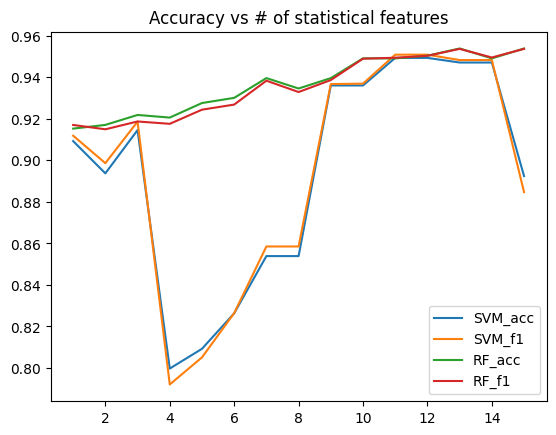

In [18]:
ax = results_all.plot(y=["SVM_acc", "SVM_f1", "RF_acc", "RF_f1"], use_index=True, title="Accuracy vs # of statistical features")